# **Regression Empirical Study：Car Price Prediction**

**Group Number:** 97  
**Members:**  
Roy Rui #300176548  
Jiayi Ma #300263220
 


---
# **Dataset I: Car Details v4.csv**
**Source**: [CarDekho - Kaggle Dataset](https://www.kaggle.com/datasets/nehalbirla/vehicle-dataset-from-cardekho/data)  
**Shape**: **20 Columns, 2059 Rows**  

## **Description**
This dataset contains **detailed information about used cars**, including specifications such as engine capacity, max power, max torque, drivetrain, and seating capacity. It is useful for price prediction using regression models and can also be applied for feature engineering, classification, and exploratory data analysis.

## **Columns and Features**  

| **Feature**           | **Description**  | **Data Type**   |
|----------------------|-----------------|-----------------|
| `Make`              | Manufacturer of the car (e.g., Honda, Toyota) | Categorical |
| `Model`             | Specific model name of the car | Categorical |
| `Price`             | Selling price of the car (Target Variable) | Numerical |
| `Year`              | Year of manufacturing | Numerical |
| `Kilometer`         | Distance driven by the car (mileage) | Numerical |
| `Fuel Type`         | Type of fuel used (Petrol/Diesel/CNG) | Categorical |
| `Transmission`      | Type of transmission (Manual/Automatic) | Categorical |
| `Location`          | City where the car is listed for sale | Categorical |
| `Color`            | Exterior color of the car | Categorical |
| `Owner`            | Number of previous owners | Categorical |
| `Seller Type`      | Type of seller (Individual/Dealer/Corporate) | Categorical |
| `Engine`           | Engine displacement in cc | Numerical (with Units) |
| `Max Power`        | Maximum power output (bhp) | Categorical |
| `Max Torque`       | Maximum torque output (Nm) | Categorical |
| `Drivetrain`       | Drivetrain type (FWD/RWD/AWD) | Categorical |
| `Length`           | Length of the vehicle (mm) | Numerical |
| `Width`            | Width of the vehicle (mm) | Numerical |
| `Height`           | Height of the vehicle (mm) | Numerical |
| `Seating Capacity` | Number of seats available | Numerical |
| `Fuel Tank Capacity` | Fuel tank size (liters) | Numerical |

This dataset is **suitable for building predictive models** and understanding **factors influencing used car prices**.



## **General Imports**

In [570]:
import pandas as pd
import numpy as np
import re, datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Lasso, Ridge

# Load dataset
df = pd.read_csv("dataset1/car details v4.csv")


---

## **Data Cleaning**

In [571]:
# Display basic information
print("Dataset Overview:\n")
print(df.info())

# Check missing values
print("\nMissing Values:\n", df.isnull().sum())

# Show first few rows
df.head()

Dataset Overview:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2059 entries, 0 to 2058
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Make                2059 non-null   object 
 1   Model               2059 non-null   object 
 2   Price               2059 non-null   int64  
 3   Year                2059 non-null   int64  
 4   Kilometer           2059 non-null   int64  
 5   Fuel Type           2059 non-null   object 
 6   Transmission        2059 non-null   object 
 7   Location            2059 non-null   object 
 8   Color               2059 non-null   object 
 9   Owner               2059 non-null   object 
 10  Seller Type         2059 non-null   object 
 11  Engine              1979 non-null   object 
 12  Max Power           1979 non-null   object 
 13  Max Torque          1979 non-null   object 
 14  Drivetrain          1923 non-null   object 
 15  Length              1995 non-null   

,Make,Model,Price,Year,Kilometer,Fuel Type,Transmission,Location,Color,Owner,Seller Type,Engine,Max Power,Max Torque,Drivetrain,Length,Width,Height,Seating Capacity,Fuel Tank Capacity
0,Honda,Amaze 1.2 VX i-VTEC,505000,2017,87150,Petrol,Manual,Pune,Grey,First,Corporate,1198 cc,87 bhp @ 6000 rpm,109 Nm @ 4500 rpm,FWD,3990.0,1680.0,1505.0,5.0,35.0
1,Maruti Suzuki,Swift DZire VDI,450000,2014,75000,Diesel,Manual,Ludhiana,White,Second,Individual,1248 cc,74 bhp @ 4000 rpm,190 Nm @ 2000 rpm,FWD,3995.0,1695.0,1555.0,5.0,42.0
2,Hyundai,i10 Magna 1.2 Kappa2,220000,2011,67000,Petrol,Manual,Lucknow,Maroon,First,Individual,1197 cc,79 bhp @ 6000 rpm,112.7619 Nm @ 4000 rpm,FWD,3585.0,1595.0,1550.0,5.0,35.0
3,Toyota,Glanza G,799000,2019,37500,Petrol,Manual,Mangalore,Red,First,Individual,1197 cc,82 bhp @ 6000 rpm,113 Nm @ 4200 rpm,FWD,3995.0,1745.0,1510.0,5.0,37.0
4,Toyota,Innova 2.4 VX 7 STR [2016-2020],1950000,2018,69000,Diesel,Manual,Mumbai,Grey,First,Individual,2393 cc,148 bhp @ 3400 rpm,343 Nm @ 1400 rpm,RWD,4735.0,1830.0,1795.0,7.0,55.0


In [572]:
def extract_numerical(value):
    if isinstance(value, str):
        numbers = re.findall(r"[-+]?\d*\.\d+|\d+", value)
        return float(numbers[0]) if numbers else None
    return value

# Apply extraction to relevant columns
df["Engine"] = df["Engine"].apply(extract_numerical)

numerical_cols = ["Engine", "Length", "Width", "Height","Seating Capacity", "Fuel Tank Capacity"]
for col in numerical_cols:
    df[col] = df.groupby("Make")[col].transform(lambda x: x.fillna(x.median()))

categorical_cols = ["Drivetrain","Max Power", "Max Torque"]
for col in categorical_cols:
    df[col] = df.groupby("Make")[col].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "Unknown"))
    
print(df.isnull().sum())


Make                  0
Model                 0
Price                 0
Year                  0
Kilometer             0
Fuel Type             0
Transmission          0
Location              0
Color                 0
Owner                 0
Seller Type           0
Engine                0
Max Power             0
Max Torque            0
Drivetrain            0
Length                0
Width                 0
Height                0
Seating Capacity      0
Fuel Tank Capacity    1
dtype: int64


c:\Users\Roy\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [573]:
df["Fuel Tank Capacity"] = df["Fuel Tank Capacity"].fillna(df["Fuel Tank Capacity"].median())
print("\nMissing Values After Fix （RuntimeWarning):\n", df.isnull().sum())


Missing Values After Fix （RuntimeWarning):
 Make                  0
Model                 0
Price                 0
Year                  0
Kilometer             0
Fuel Type             0
Transmission          0
Location              0
Color                 0
Owner                 0
Seller Type           0
Engine                0
Max Power             0
Max Torque            0
Drivetrain            0
Length                0
Width                 0
Height                0
Seating Capacity      0
Fuel Tank Capacity    0
dtype: int64


---

## **Categorical Feature Encoding (One-Hot Encoding)**

In [574]:
# List of categorical columns to encode
categorical_cols = ["Make", "Model", "Fuel Type", "Transmission", "Location", 
                    "Color", "Owner", "Seller Type", "Drivetrain"]

# Apply one-hot encoding
encoder = OneHotEncoder(drop='first', sparse_output=False)  # drop='first' to avoid dummy variable trap
encoded_categorical = encoder.fit_transform(df[categorical_cols])

# Convert the encoded array to a DataFrame
encoded_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(categorical_cols))

# Drop original categorical columns and merge with the new encoded columns
df = df.drop(columns=categorical_cols).reset_index(drop=True)
df = pd.concat([df, encoded_df], axis=1)

# Display the transformed DataFrame
display(df.head())


,Price,Year,Kilometer,Engine,Max Power,Max Torque,Length,Width,Height,Seating Capacity,...,Color_Yellow,Owner_First,Owner_Fourth,Owner_Second,Owner_Third,Owner_UnRegistered Car,Seller Type_Corporate,Seller Type_Individual,Drivetrain_FWD,Drivetrain_RWD
0,505000,2017,87150,1198.0,87 bhp @ 6000 rpm,109 Nm @ 4500 rpm,3990.0,1680.0,1505.0,5.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,450000,2014,75000,1248.0,74 bhp @ 4000 rpm,190 Nm @ 2000 rpm,3995.0,1695.0,1555.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
2,220000,2011,67000,1197.0,79 bhp @ 6000 rpm,112.7619 Nm @ 4000 rpm,3585.0,1595.0,1550.0,5.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,799000,2019,37500,1197.0,82 bhp @ 6000 rpm,113 Nm @ 4200 rpm,3995.0,1745.0,1510.0,5.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,1950000,2018,69000,2393.0,148 bhp @ 3400 rpm,343 Nm @ 1400 rpm,4735.0,1830.0,1795.0,7.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0



---

## **EDA and Outlier detection**

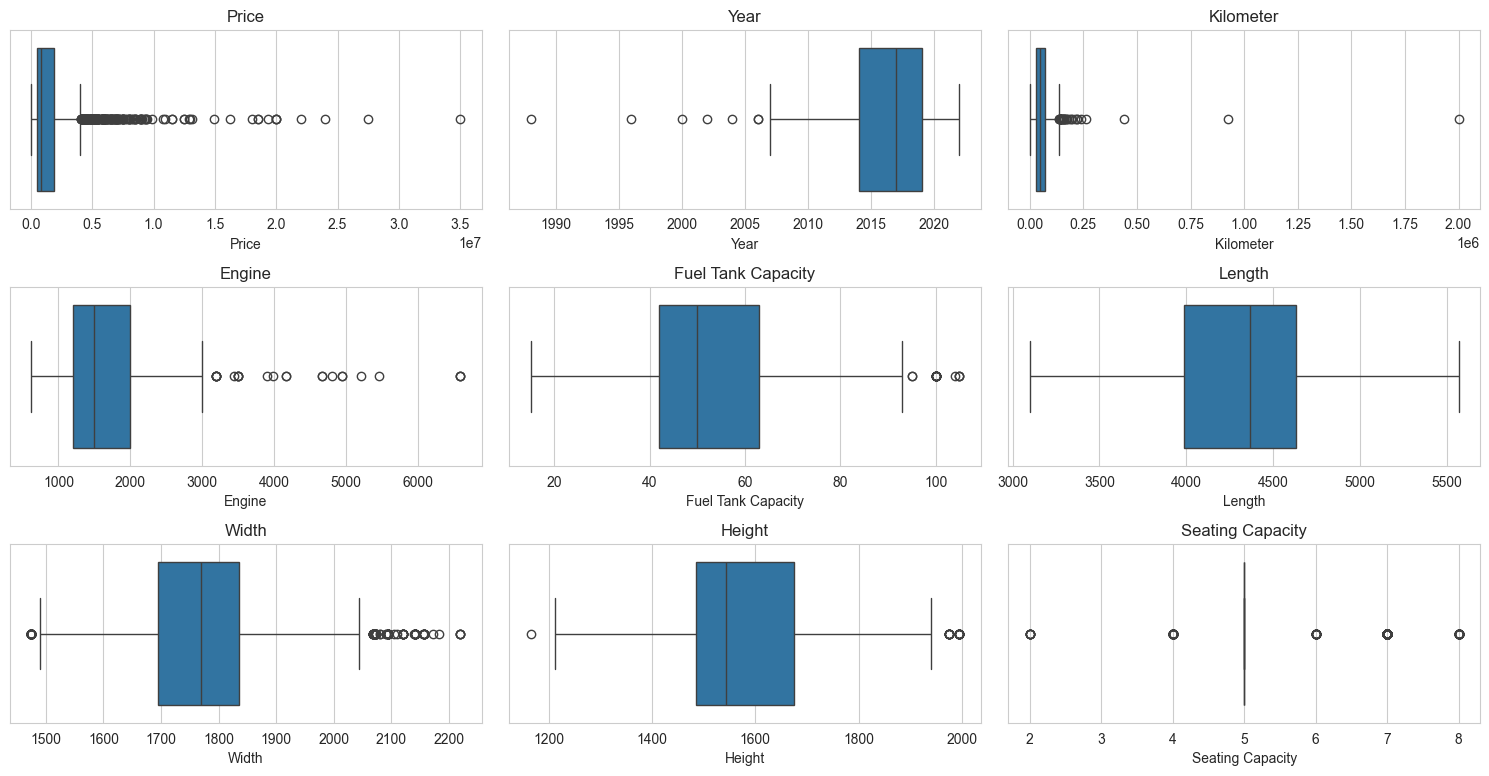

In [575]:
# Select numerical columns
numerical_cols = ["Price", "Year", "Kilometer", "Engine", "Fuel Tank Capacity", "Length", "Width", "Height", "Seating Capacity"]

# Set up boxplots for each numerical column
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(x=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()

In [576]:
# Select feature(s) with detected outliers (Example: "Price" and "Kilometer")
outlier_features = ["Price", "Kilometer"]

# Apply LOF
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)  # Adjust contamination if needed
outliers = lof.fit_predict(df[outlier_features])

# Convert -1 (outliers) to boolean mask
df["Outlier"] = (outliers == -1)

# Display detected outliers
display(df[df["Outlier"]])

,Price,Year,Kilometer,Engine,Max Power,Max Torque,Length,Width,Height,Seating Capacity,...,Owner_First,Owner_Fourth,Owner_Second,Owner_Third,Owner_UnRegistered Car,Seller Type_Corporate,Seller Type_Individual,Drivetrain_FWD,Drivetrain_RWD,Outlier
68,190000,2006,130000,1799.0,130 bhp @ 6300 rpm,171.62 Nm @ 4300 rpm,4545.0,1750.0,1450.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,True
95,16200000,2022,2766,2995.0,335 bhp @ 5300 rpm,450 Nm @ 1340 rpm,4931.0,1983.0,1676.0,4.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,True
112,1400000,2014,143000,2982.0,169 bhp @ 3600 rpm,360 Nm @ 1400 rpm,4705.0,1840.0,1850.0,7.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,True
134,1490000,2013,195000,1995.0,184 bhp @ 4000 rpm,380 Nm @ 1750 rpm,4899.0,2094.0,1464.0,5.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,True
160,11500000,2016,27000,4663.0,453 bhp @ 5250 rpm,700 Nm @ 1800 rpm,5453.0,1899.0,1498.0,4.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004,335000,2008,140987,2987.0,198@4000,456@1400,4818.0,1822.0,1420.0,5.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,True
2021,3250000,2018,173000,2755.0,174 bhp @ 3400 rpm,420 Nm @ 1600 rpm,4795.0,1855.0,1835.0,7.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,True
2023,735000,2015,121000,2179.0,138 bhp @ 3750 rpm,330 Nm @ 1600 rpm,4585.0,1890.0,1785.0,7.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,True
2036,1000000,2010,127000,2982.0,171@3600,343@1400,4695.0,1840.0,1850.0,7.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,True


We decided to remove outliers because they account for only 103 rows, which is a small fraction compared to the total dataset size. Keeping these extreme values could negatively impact model performance, especially in linear regression. Removing them ensures a more robust and generalizable model without significantly affecting the dataset's overall information.


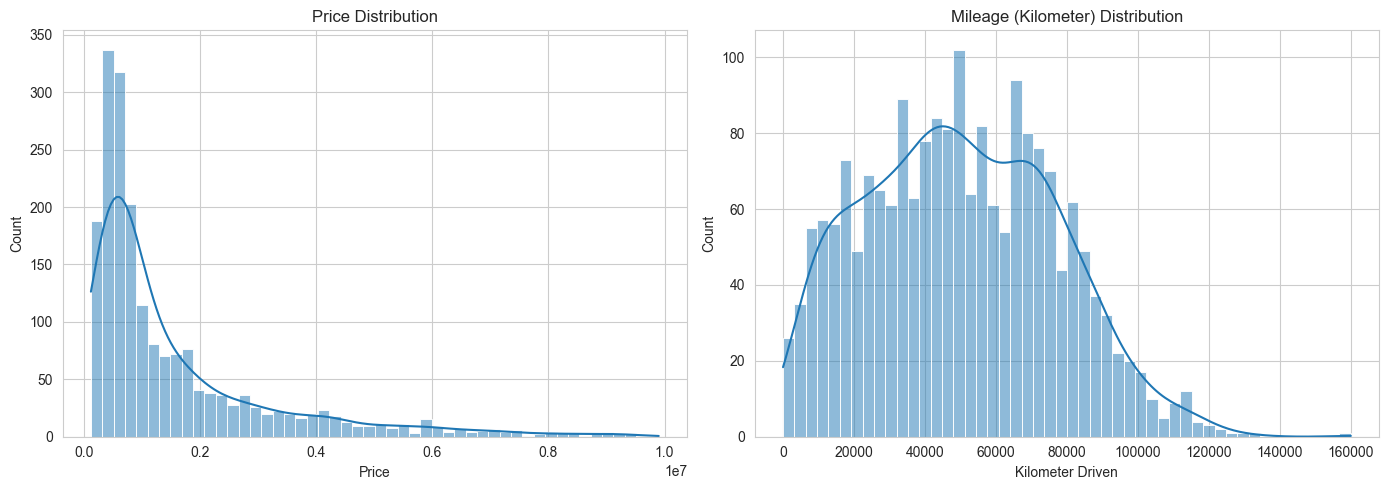

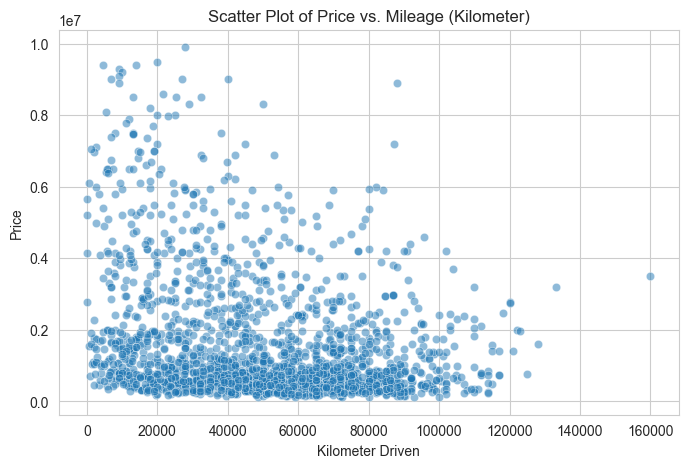

Pearson Correlation Coefficient: -0.2774


In [577]:
df_cleaned = df[df["Outlier"] == False].drop(columns=["Outlier"])

# Display cleaned DataFrame

# Set style
sns.set_style("whitegrid")

# Create subplots for visualizing price and mileage (kilometer)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Price distribution
sns.histplot(df_cleaned["Price"], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Price Distribution")
axes[0].set_xlabel("Price")
axes[0].set_ylabel("Count")

# Mileage (Kilometer) distribution
sns.histplot(df_cleaned["Kilometer"], bins=50, kde=True, ax=axes[1])
axes[1].set_title("Mileage (Kilometer) Distribution")
axes[1].set_xlabel("Kilometer Driven")
axes[1].set_ylabel("Count")

# Show plots
plt.tight_layout()
plt.show()

# Scatter plot to visualize correlation
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df_cleaned["Kilometer"], y=df_cleaned["Price"], alpha=0.5)
plt.title("Scatter Plot of Price vs. Mileage (Kilometer)")
plt.xlabel("Kilometer Driven")
plt.ylabel("Price")
plt.show()

# Compute Pearson correlation coefficient
correlation = np.corrcoef(df_cleaned["Kilometer"], df_cleaned["Price"])[0, 1]
print(f"Pearson Correlation Coefficient: {correlation:.4f}")

We can see that there is a weak to moderate negative correlation between Price and Mileage. Now we want to inspect the correlationships each numerical feature with the target variable `Price`

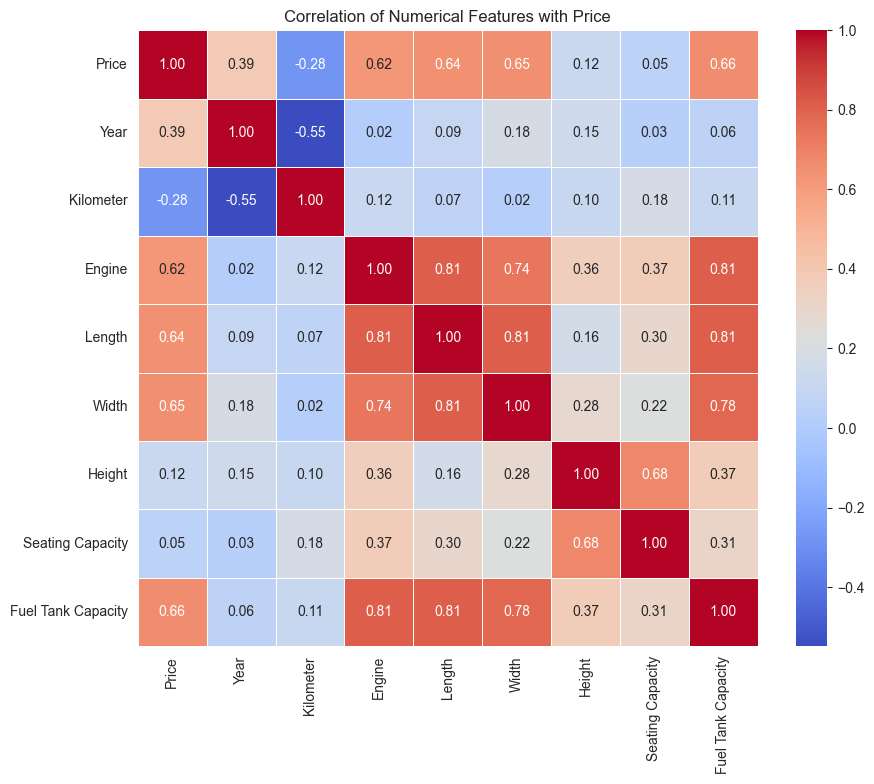

In [578]:
# Select only numerical columns (excluding categorical one-hot encoded features)
numerical_cols = ["Price", "Year", "Kilometer", "Engine", "Length", "Width", "Height", "Seating Capacity", "Fuel Tank Capacity"]

# Compute correlation matrix
correlation_matrix = df_cleaned[numerical_cols].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation of Numerical Features with Price")
plt.show()

The correlation heatmap reveals several key relationships between numerical features and car prices. Price has a strong positive correlation with Engine size (0.62), Length (0.64), Width (0.65), and Fuel Tank Capacity (0.66), indicating that larger vehicles with bigger engines and fuel tanks tend to be more expensive. Kilometer driven (-0.28) has a negative correlation with price, suggesting that higher mileage generally reduces a car’s value. Year (0.39) has a moderate positive correlation, meaning newer cars tend to be priced higher. Seating Capacity (0.05) and Height (0.12) show little correlation, implying these features have minimal impact on price.


---

## **Predictive Analysis: Linear Regression**

Since handleing Max Power and Max Torque (e.g. 87 bhp @ 6000 rpm  109 Nm @ 4500 rpm) requires domain knowledge of cars, we decided to exclude these features for now. Length, Width, and Height are saved for feature engineering. As for the seating capacity, since those are showing weak correlation to the price.

In [579]:
# Selecting more relevant numerical and encoded categorical features
numerical_features = [
    "Year", "Kilometer", "Engine", "Fuel Tank Capacity"
]

# Include all one-hot encoded categorical features
categorical_features = [col for col in df_cleaned.columns if col.startswith(("Make_", "Model_", "Fuel Type_", "Transmission_", "Owner_", "Seller Type_", "Drivetrain_"))]

# Combine numerical and categorical features
selected_features = numerical_features + categorical_features

# Define new feature set
X = df_cleaned[selected_features]  # Features
y = df_cleaned["Price"]  # Target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print evaluation results
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

MAE: 418604.60
MSE: 530256558280.58
RMSE: 728187.17
R² Score: 0.8142


### **Regression Model Comparison**

### **Results Summary**
| Model        | MAE (↓)      | MSE (↓)        | RMSE (↓)      | R² Score (↑) |
|-------------|-------------|---------------|--------------|-------------|
| **Ridge**   | 432,639.99  | 530,597,756,934.86  | 728,421.41  | 0.8141  |
| **Lasso**   | 431,817.35  | 614,851,717,433.93  | 784,124.81  | 0.7846  |
| **ElasticNet** | 726,445.18  | 1,136,629,150,446.27  | 1,066,128.11  | 0.6018  |
| **Previous Linear Regression** | **418,604.60**  | **530,256,558,280.58**  | **728,187.17**  | **0.8142**  |


#### **Conclusion**
Since Linear Regression already gives the best performance (MAE: 418,604.60, R²: 0.8142), there is no need to explore further regressions. Ridge regression provides similar results, while Lasso and ElasticNet **underperform** due to their regularization effects.

***Note that the original test codes for other models are omitted for clean looking of the notebook.***



---

## **Feature Engineering**  


Vehicle Size Index (VSI) – Aggregates Length, Width, and Height to represent the overall size of the vehicle:  

***VSI=Length×Width×Height***

Power-to-Torque Ratio:  

***Ratio of power (bhp) to torque (Nm): Power / Torque***

In [580]:
# Copy the DataFrames
df_FG = df.copy()
df_cleaned_FG = df_cleaned.copy()

# Vehicle Size Index (VSI)
df_FG["Vehicle_Size_Index"] = df_FG["Length"] * df_FG["Width"] * df_FG["Height"]
df_cleaned_FG["Vehicle_Size_Index"] = df_cleaned_FG["Length"] * df_cleaned_FG["Width"] * df_cleaned_FG["Height"]

# Function to extract numerical values from power column
def extract_power(power_str):
    match = re.search(r"(\d+(\.\d+)?)\s*bhp", str(power_str))
    return float(match.group(1)) if match else None

# Function to extract numerical values from torque column
def extract_torque(torque_str):
    match = re.search(r"(\d+(\.\d+)?)\s*Nm", str(torque_str))
    return float(match.group(1)) if match else None

# Apply extraction on both datasets
df_FG["Max_Power_Num"] = df_FG["Max Power"].apply(extract_power)
df_FG["Max_Torque_Num"] = df_FG["Max Torque"].apply(extract_torque)

df_cleaned_FG["Max_Power_Num"] = df_cleaned_FG["Max Power"].apply(extract_power)
df_cleaned_FG["Max_Torque_Num"] = df_cleaned_FG["Max Torque"].apply(extract_torque)

# Fill missing values with mode (Since this happens during implementation)
df_FG.loc[:, "Max_Power_Num"] = df_FG["Max_Power_Num"].fillna(df_FG["Max_Power_Num"].mode()[0])
df_FG.loc[:, "Max_Torque_Num"] = df_FG["Max_Torque_Num"].fillna(df_FG["Max_Torque_Num"].mode()[0])

df_cleaned_FG.loc[:, "Max_Power_Num"] = df_cleaned_FG["Max_Power_Num"].fillna(df_cleaned_FG["Max_Power_Num"].mode()[0])
df_cleaned_FG.loc[:, "Max_Torque_Num"] = df_cleaned_FG["Max_Torque_Num"].fillna(df_cleaned_FG["Max_Torque_Num"].mode()[0])


# Compute feature aggregation
df_FG["Power_Torque_Ratio"] = df_FG["Max_Power_Num"] / df_FG["Max_Torque_Num"]
df_FG["Normalized_Power"] = df_FG["Max_Power_Num"] / df_FG["Engine"]
df_FG["Normalized_Torque"] = df_FG["Max_Torque_Num"] / df_FG["Engine"]

df_cleaned_FG["Power_Torque_Ratio"] = df_cleaned_FG["Max_Power_Num"] / df_cleaned_FG["Max_Torque_Num"]
df_cleaned_FG["Normalized_Power"] = df_cleaned_FG["Max_Power_Num"] / df_cleaned_FG["Engine"]
df_cleaned_FG["Normalized_Torque"] = df_cleaned_FG["Max_Torque_Num"] / df_cleaned_FG["Engine"]

# Display results
display(df_FG[["Vehicle_Size_Index", "Power_Torque_Ratio", "Normalized_Power", "Normalized_Torque"]].isnull().sum())
display(df_cleaned_FG[["Vehicle_Size_Index", "Power_Torque_Ratio", "Normalized_Power", "Normalized_Torque"]].isnull().sum())
display(df_FG[["Vehicle_Size_Index", "Power_Torque_Ratio", "Normalized_Power", "Normalized_Torque"]].head())
display(df_cleaned_FG[["Vehicle_Size_Index", "Power_Torque_Ratio", "Normalized_Power", "Normalized_Torque"]].head())


Vehicle_Size_Index    0
Power_Torque_Ratio    0
Normalized_Power      0
Normalized_Torque     0
dtype: int64

Vehicle_Size_Index    0
Power_Torque_Ratio    0
Normalized_Power      0
Normalized_Torque     0
dtype: int64

,Vehicle_Size_Index,Power_Torque_Ratio,Normalized_Power,Normalized_Torque
0,1.008832e+10,0.798165,0.072621,0.090985
1,1.052972e+10,0.389474,0.059295,0.152244
2,8.863016e+09,0.700591,0.065998,0.094204
3,1.052663e+10,0.725664,0.068505,0.094403
4,1.555376e+10,0.431487,0.061847,0.143335


,Vehicle_Size_Index,Power_Torque_Ratio,Normalized_Power,Normalized_Torque
0,1.008832e+10,0.798165,0.072621,0.090985
1,1.052972e+10,0.389474,0.059295,0.152244
2,8.863016e+09,0.700591,0.065998,0.094204
3,1.052663e+10,0.725664,0.068505,0.094403
4,1.555376e+10,0.431487,0.061847,0.143335



---

## **Empirical study**  

We will define features and target for all four dataset versions:

- Baseline: `df` (no outlier removal, no feature aggregation)
- Outlier Removal Only: `df_cleaned`
- Feature Aggregation Only: `df_FG`
- Outlier Removal + Feature Aggregation: `df_cleaned_FG`

### **Define Feature Sets**

In [581]:
# Define the feature and target variable for all datasets
datasets = {
    "Baseline": df,
    "Outlier Removal": df_cleaned,
    "Feature Aggregation": df_FG,
    "Outlier Removal + Feature Aggregation": df_cleaned_FG
}

# Select numerical features and one-hot encoded categorical features
numerical_features = ["Year", "Kilometer", "Engine"]
categorical_features = [col for col in df.columns if col.startswith(("Make_", "Model_", "Fuel Type_", "Transmission_", "Owner_", "Seller Type_", "Drivetrain_"))]
baseline_features = numerical_features + categorical_features
fG_features = baseline_features + ["Vehicle_Size_Index", "Power_Torque_Ratio", "Normalized_Power", "Normalized_Torque"]


### **Train-Test Split**

We reserve 20% of data as the final Test Set (DT) that will not be used in training.

In [582]:
# Create the test set DT from the Baseline dataset (Same split applied to all datasets)
D = df[baseline_features]
y = df["Price"]

# Reserve 20% of the dataset as a test set (DT)
D_train, DT_test, y_train, y_test = train_test_split(D, y, test_size=0.2, random_state=42)

print(f"Train set size: {D_train.shape}, Test set size: {DT_test.shape}") 

Train set size: (1647, 1102), Test set size: (412, 1102)


### **Define Cross-Validation and Train Models**

For each dataset version (`df_cleaned`, `df_FG`, etc.), we train 4-fold cross-validation and evaluate **MSE** and **R²**.

In [583]:
# Define evaluation metrics
def evaluate_model(model, X, y):
    kf = KFold(n_splits=4, shuffle=True, random_state=42)
    mse_scores = -cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    
    return np.mean(mse_scores), np.mean(r2_scores)

# Run experiments for all dataset versions
results = {}

for name, dataset in {
    "Baseline": df,
    "Outlier Removal": df_cleaned
}.items():  

    X_train = dataset[baseline_features]  # Features including new aggregated ones
    y_train = dataset["Price"]  # Target variable

    model = LinearRegression()
    mse, r2 = evaluate_model(model, X_train, y_train)

    results[name] = {"MSE": mse, "R²": r2}

for name, dataset in {
    "Feature Aggregation": df_FG,
    "Outlier Removal + Feature Aggregation": df_cleaned_FG
}.items():  # Make sure the datasets with added features are used

    X_train = dataset[fG_features]  # Features including new aggregated ones
    y_train = dataset["Price"]  # Target variable

    model = LinearRegression()
    mse, r2 = evaluate_model(model, X_train, y_train)

    results[name] = {"MSE": mse, "R²": r2}


# Display results
df_results = pd.DataFrame(results).T
display(df_results)

,MSE,R²
Baseline,1.968113e+12,0.669744
Outlier Removal,4.527059e+11,0.845498
Feature Aggregation,1.857861e+12,0.690407
Outlier Removal + Feature Aggregation,4.684164e+11,0.839707


### **Select the Best Model & Evaluate on Final Test Set**

After comparing **MSE** and ***R²***, we choose the best system and evaluate it on DT.

In [584]:
# Choose the best system based on highest R²
best_system = df_results["R²"].idxmax()
print(f"Best system selected: {best_system}")

# Train the best model on full training set and evaluate on test set (DT)
best_X_train = datasets[best_system][baseline_features]
best_y_train = datasets[best_system]["Price"]

final_model = LinearRegression()
final_model.fit(best_X_train, best_y_train)

final_features = best_X_train.columns
# Evaluate on the final test set (DT)
DT_X = DT_test[final_features]
DT_y_pred = final_model.predict(DT_X)

# Final performance metrics
final_mse = mean_squared_error(y_test, DT_y_pred)
final_r2 = r2_score(y_test, DT_y_pred)

print(f"Final Test MSE: {final_mse:.2f}")
print(f"Final Test R² Score: {final_r2:.4f}")


Best system selected: Outlier Removal
Final Test MSE: 2967485162315.30
Final Test R² Score: 0.5752


## **What if we use Ridge regression instead of Linear Regression?**

In [585]:
ridge_model = Ridge(alpha=1.0)  # You can tune alpha for better performance
ridge_model.fit(best_X_train, best_y_train)

final_features = best_X_train.columns
# Evaluate on the final test set (DT)
DT_X = DT_test[final_features]
DT_y_pred = ridge_model.predict(DT_X)

# Final performance metrics
mse = mean_squared_error(y_test, DT_y_pred)
r2 = r2_score(y_test, DT_y_pred)

print(f"Final Test MSE: {mse:.2f}")
print(f"Final Test R² Score: {r2:.4f}")


Final Test MSE: 2914194409138.49
Final Test R² Score: 0.5829


## **BOOM! Does not change much! Even with Lasso :(**

In [586]:
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(best_X_train, best_y_train)

final_features = best_X_train.columns
# Evaluate on the final test set (DT)
DT_X = DT_test[final_features]
DT_y_pred = lasso_model.predict(DT_X)

# Final performance metrics
mse = mean_squared_error(y_test, DT_y_pred)
r2 = r2_score(y_test, DT_y_pred)

print(f"Final Test MSE: {mse:.2f}")
print(f"Final Test R² Score: {r2:.4f}")

Final Test MSE: 2813528740327.73
Final Test R² Score: 0.5973


c:\Users\Roy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.921e+13, tolerance: 5.730e+11
  model = cd_fast.enet_coordinate_descent(
